In [9]:
#tutorial: https://towardsdatascience.com/sentiment-analysis-of-stocks-from-financial-news-using-python-82ebdcefb638
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import urllib
import urllib.request
import requests
import nltk
import seaborn as sns
from bs4 import BeautifulSoup
import os
from flask import request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
pd.set_option('display.max_colwidth', -1)


C:\Users\PRM\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  from ipykernel import kernelapp as app


# Parsing Stock Info

In [11]:
finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}

tickers = ['DIS']

for ticker in tickers:
    url = finwiz_url + ticker
    req = urllib.request.Request(url=url,headers={'user-agent': 'my-app/0.0.1'})
    response = urllib.request.urlopen(req)
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [7]:
vr = news_tables['DIS']

# Analysis: Pulls the top 10 most recent articles for ticker symbol ___ (Not all dates are placed)

In [8]:
vr_tr = vr.findAll('tr')
vr_tr

for i, table_row in enumerate(vr_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 5:
        break

The Batman rules box office again, while BTS concert makes a pop
Mar-13-22 04:40PM  
Disney Has More New Attractions Coming to its Florida Theme Parks
Mar-12-22 08:27PM  
Disney CEO Makes It Clear a Big Price Increase Is Coming (Here's When)
08:24PM  
Why Disney+ Subscriber Growth Is About to Explode
09:00AM  
Is It a Good Time To Buy a House? (Here's What You Should Know.)
08:00AM  
Disneys Bob Chapek apologises to staff over response to Dont Say Gay bill
Mar-11-22 08:56PM  


# Pulling articles for ticker symbol ___ and print ticker info. to a list

In [22]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
pd.DataFrame(parsed_news,columns=('ticker','date','time','article')).head(15)

,ticker,date,time,article
0,DIS,Mar-13-22,04:40PM,"The Batman rules box office again, while BTS concert makes a pop"
1,DIS,Mar-12-22,08:27PM,Disney Has More New Attractions Coming to its Florida Theme Parks
2,DIS,Mar-12-22,08:24PM,Disney CEO Makes It Clear a Big Price Increase Is Coming (Here's When)
3,DIS,Mar-12-22,09:00AM,Why Disney+ Subscriber Growth Is About to Explode
4,DIS,Mar-12-22,08:00AM,Is It a Good Time To Buy a House? (Here's What You Should Know.)
5,DIS,Mar-11-22,08:56PM,Disneys Bob Chapek apologises to staff over response to Dont Say Gay bill
6,DIS,Mar-11-22,07:26PM,"Disney CEO Tried to Avoid Politics, Now Finds Himself in Middle of Partisan Spat"
7,DIS,Mar-11-22,02:40PM,UPDATE 2-Disney to pause Florida political donations over law limiting LGBTQ discussion
8,DIS,Mar-11-22,01:47PM,"Rihanna's Savage X Fenty eyes $3B IPO, expanding empire, female entrepreneur status"
9,DIS,Mar-11-22,11:30AM,Why Is Disney (DIS) Down 12.2% Since Last Earnings Report?


In [24]:
pd.DataFrame(parsed_news,columns=('ticker','date','time','article')).shape

(100, 4)

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PRM\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Sentimental Analysis

In [31]:
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news['date'])
parsed_and_scored_news.head()


#compound - sentiment score - the higher the more positive (-1,1)
#

,ticker,date,time,headline,neg,neu,pos,compound
0,DIS,2022-03-13,04:40PM,"The Batman rules box office again, while BTS concert makes a pop",0.0,1.000,0.000,0.0000
1,DIS,2022-03-12,08:27PM,Disney Has More New Attractions Coming to its Florida Theme Parks,0.0,0.765,0.235,0.4728
2,DIS,2022-03-12,08:24PM,Disney CEO Makes It Clear a Big Price Increase Is Coming (Here's When),0.0,0.671,0.329,0.5994
3,DIS,2022-03-12,09:00AM,Why Disney+ Subscriber Growth Is About to Explode,0.0,0.729,0.271,0.3818
4,DIS,2022-03-12,08:00AM,Is It a Good Time To Buy a House? (Here's What You Should Know.),0.0,0.791,0.209,0.4404


In [32]:
parsed_and_scored_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ticker    100 non-null    object        
 1   date      100 non-null    datetime64[ns]
 2   time      100 non-null    object        
 3   headline  100 non-null    object        
 4   neg       100 non-null    float64       
 5   neu       100 non-null    float64       
 6   pos       100 non-null    float64       
 7   compound  100 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 5.1+ KB


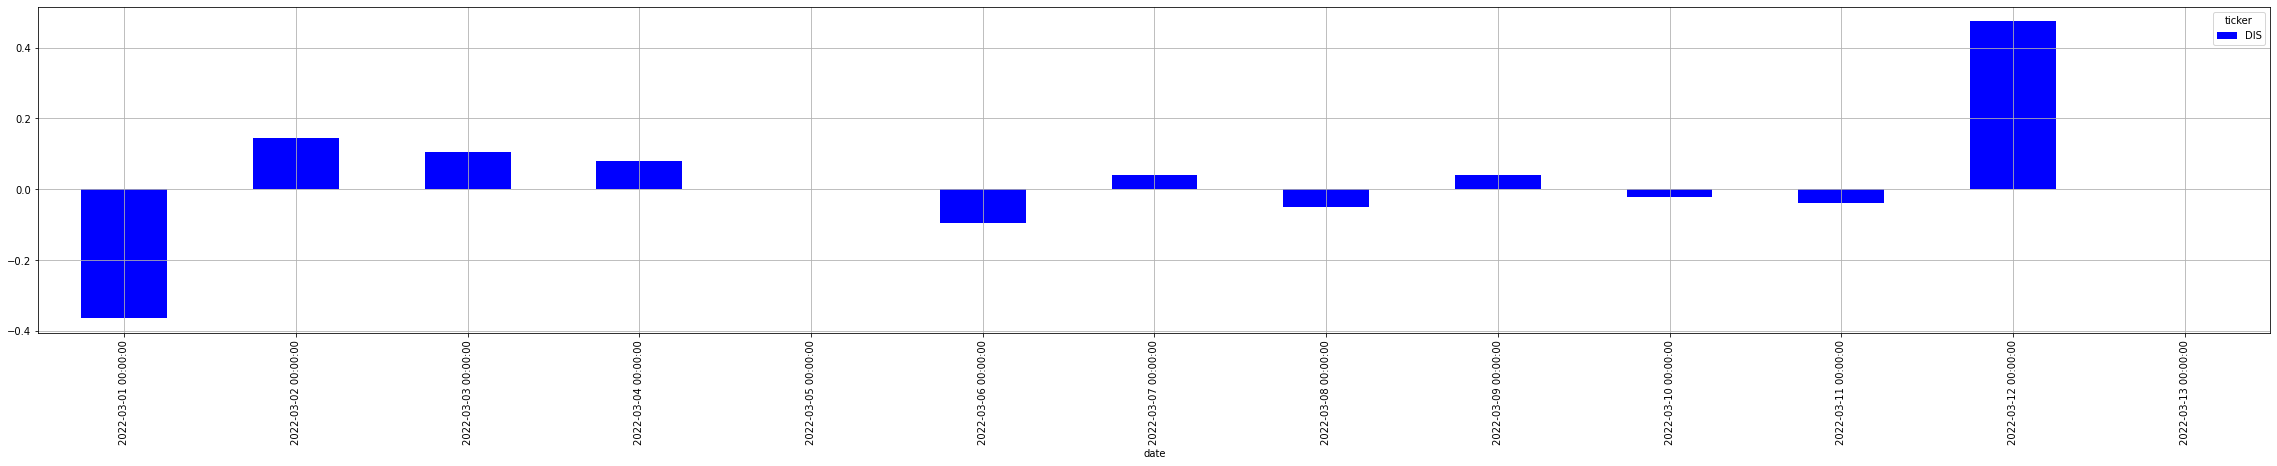

In [34]:
plt.rcParams['figure.figsize'] = [40, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar',color= ['blue','green','orange', 'red','purple'])



plt.grid()

In [37]:
import textwrap

cols = ['Very Long Column Title ' + str(i) for i in range(2)]

# Split wide columns, you can then join these with any delimiter you'd like
cols = [textwrap.wrap(x, width=20) for x in cols]

# print(cols)
# [['Very Long Column', 'Title 0'], ['Very Long Column', 'Title 1']]


In [38]:
pd.set_option('display.max_rows', None)

In [39]:
t = parsed_and_scored_news[parsed_and_scored_news['ticker']=='aapl']
t

,ticker,date,time,headline,neg,neu,pos,compound,sentiment


In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

colors = ['#d9d9d9', "#FF0B04","#7ed957"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

#plt.rcParams['figure.figsize'] = [40, 6]
ax = sns.barplot(x='date', y='compound',hue ='sentiment', data=t)






ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

ValueError: min() arg is an empty sequence